### First part: Camera Calibration to find out the instrinsic (lens distortion) parameters

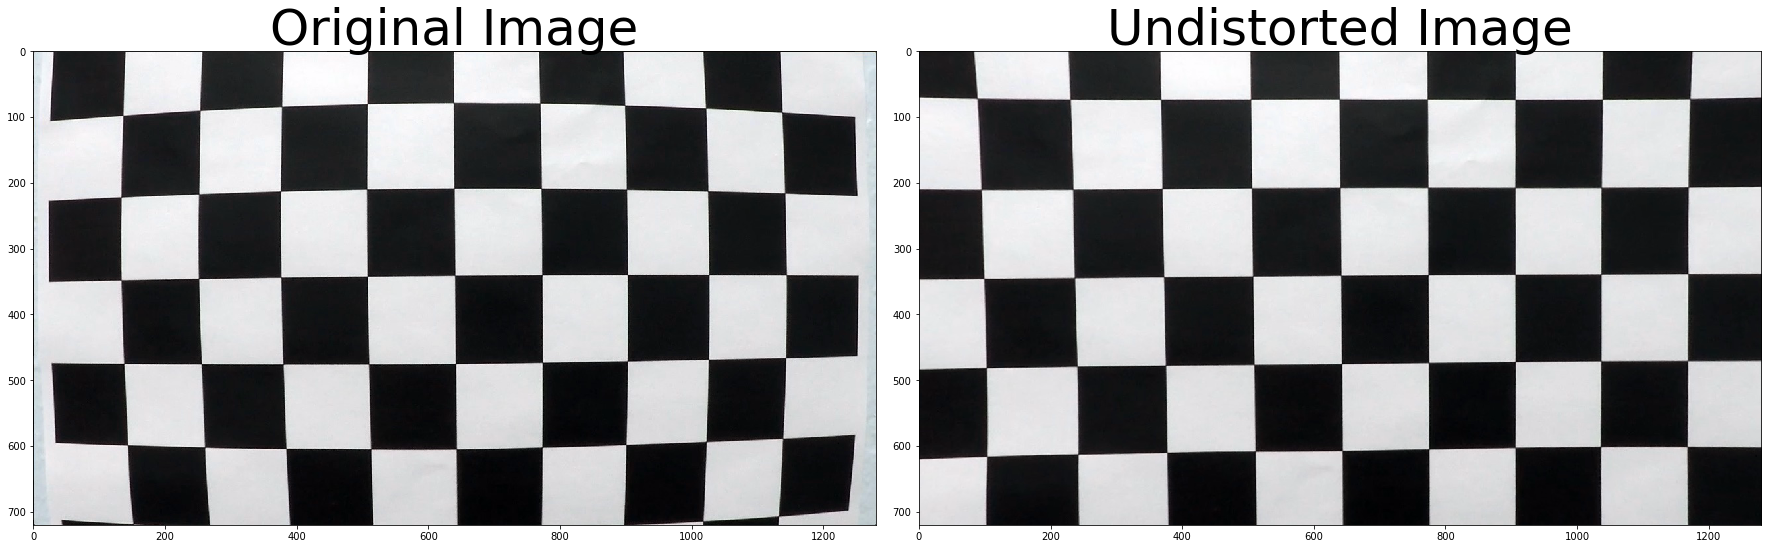

In [213]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


calib_image_dir = 'camera_cal/'
list_of_calib_images= glob.glob(calib_image_dir+'*.jpg')

#Flag to enable the testing of the Calibration by undistorting the images
test = True

# Calibration pattern
nx = 9
ny = 6


# Arrays to store object points and image points from all the images
objpoints = []
imgpoints = []


# prepare object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) 
#print(objp)

#Iterate through all the images to find the image points
for fname in list_of_calib_images:
    # Read the file
    #print(fname)
    img = cv2.imread(fname)
    #plt.imshow(img)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, add corners/imgpoints
    if ret == True:
        #print(len(corners))
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
        #f.tight_layout()
        #ax1.imshow(img)
        #ax1.set_title('Calibrating by finding imgpoints/corners in Image', fontsize=50)
        
#Now lets do camera calibration (finding the camera matrix and distortion parameters)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)

if test is True:
    fname = list_of_calib_images[0]
    
    img = cv2.imread(fname)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    
    
    
    

### Test the Camera Calibration and Distortion correction on test Images

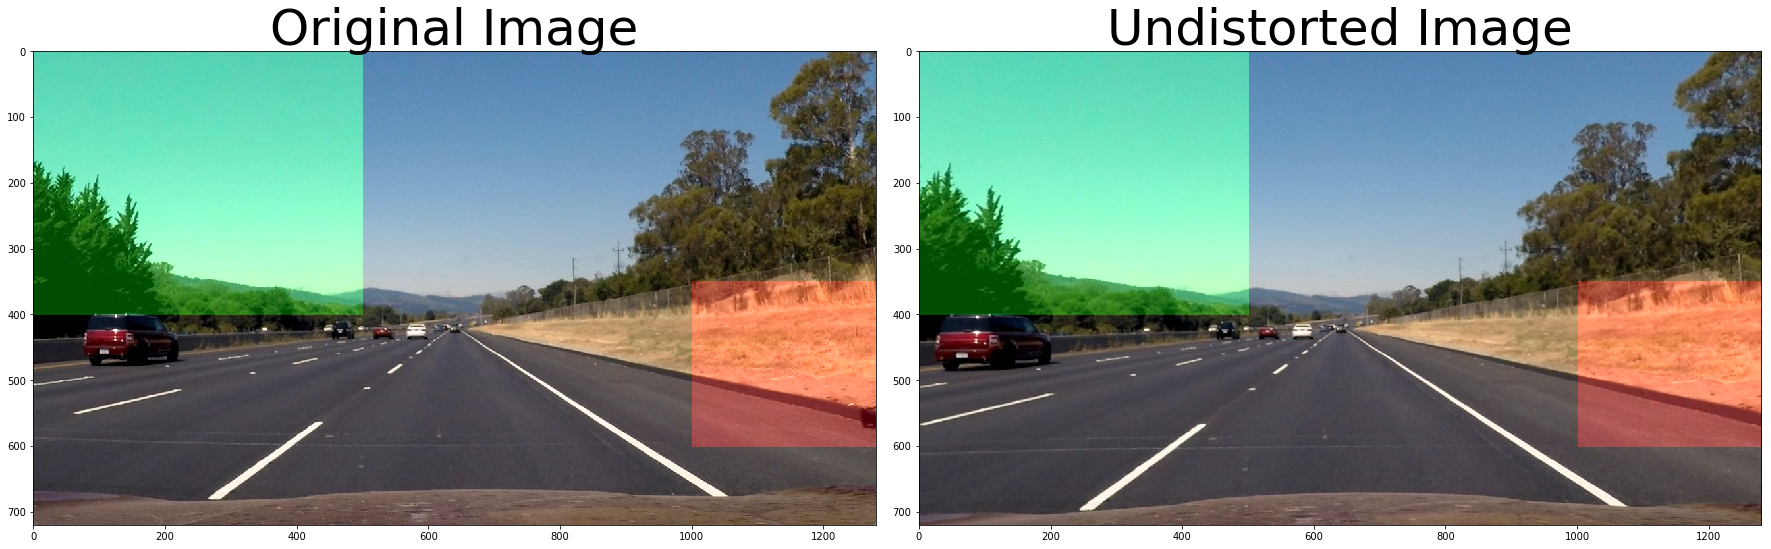

In [214]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

test_image_dir = 'test_images/'
list_of_test_images = glob.glob(test_image_dir+'*.jpg')
#print(list_of_test_images)
num = len(list_of_test_images)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
fname = list_of_test_images[1]
    
# Read the image
img = mpimg.imread(fname)

# Undistort the images
undistorted = cv2.undistort(img, mtx, dist, None, mtx)


# Create an image to draw the lines on
area = np.zeros_like(img).astype(np.uint8)
area2 = np.zeros_like(img).astype(np.uint8)
# Draw the lane onto the warped blank image
vertices = np.array([[(0,0),(500, 0), (500,400), (0, 400)]], dtype=np.int32)
cv2.fillPoly(area, vertices, (0,255, 0))

vertices = np.array([[(1000, 350),(1280, 350), (1280,600), (1000, 600)]], dtype=np.int32)
cv2.fillPoly(area2, vertices, (255,0, 0))


result = cv2.addWeighted(img, 1, area, 0.3, 0)
result = cv2.addWeighted(result, 1, area2, 0.3, 0)
ax1.imshow(result)
ax1.set_title('Original Image', fontsize=50)
result = cv2.addWeighted(undistorted, 1, area, 0.3, 0)
result = cv2.addWeighted(result, 1, area2, 0.3, 0)
ax2.imshow(result)
ax2.set_title('Undistorted Image', fontsize=50)
    
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

img = undistorted

### Gradient thresholding

In [215]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    # Calculate directional gradient
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    binary_output = np.copy(sbinary) # Remove this line

    # Return the binary image
    return binary_output

   

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

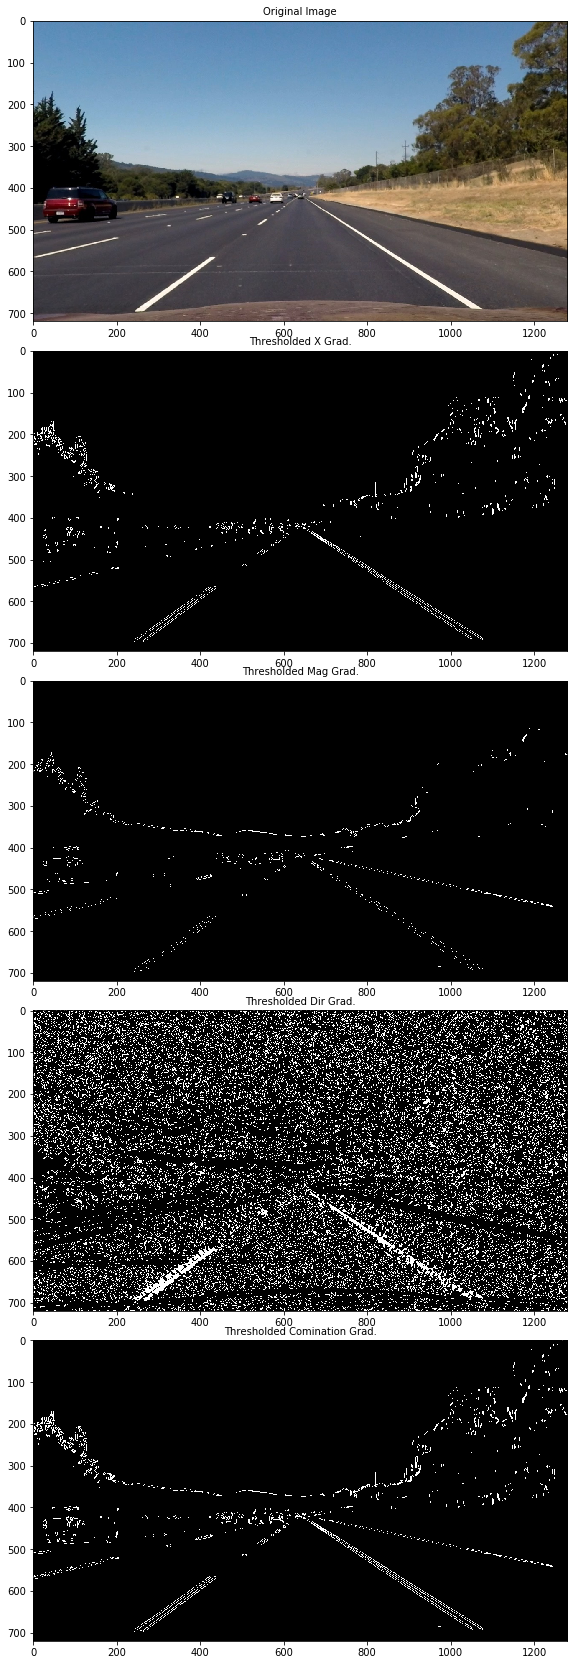

In [216]:
abs_bin_threshold_image = abs_sobel_thresh(img, sobel_kernel=11, thresh=(50, 100))
mag_bin_threshold_image = mag_thresh(img, sobel_kernel=15, thresh=(80, 100))
dir_bin_threshold_image = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.0))

com_bin_threshold_image = np.zeros_like(abs_bin_threshold_image).astype(np.uint8)
#com_bin_threshold_image[(abs_bin_threshold_image == 1) & (mag_bin_threshold_image == 1) & (dir_bin_threshold_image == 1)] = 1
com_bin_threshold_image[(abs_bin_threshold_image == 1) | (mag_bin_threshold_image == 1) ] = 1

# Plot the result
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(40, 25))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(abs_bin_threshold_image, cmap='gray')
ax2.set_title('Thresholded X Grad.', fontsize=10)
ax3.imshow(mag_bin_threshold_image, cmap='gray')
ax3.set_title('Thresholded Mag Grad.', fontsize=10)
ax4.imshow(dir_bin_threshold_image, cmap='gray')
ax4.set_title('Thresholded Dir Grad.', fontsize=10)
ax5.imshow(com_bin_threshold_image, cmap='gray')
ax5.set_title('Thresholded Comination Grad.', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Color Thresholding

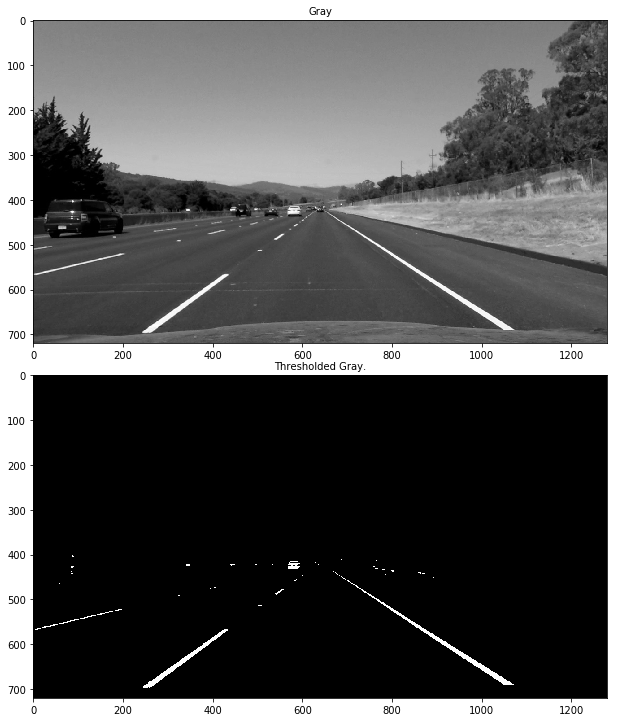

In [217]:
def color_thresh(img, thresh=(0, 255)):
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    binary_output =  np.zeros_like(img)
    binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
hls  = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

r = img[:,:,0]
h = hls[:,:,0]
l = hls[:,:,1]
s = hls[:,:,2]


gray_bin = color_thresh(gray, thresh=(200, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
f.tight_layout()
ax1.imshow(gray, cmap='gray')
ax1.set_title('Gray', fontsize=10)
ax2.imshow(gray_bin, cmap='gray')
ax2.set_title('Thresholded Gray.', fontsize=10)


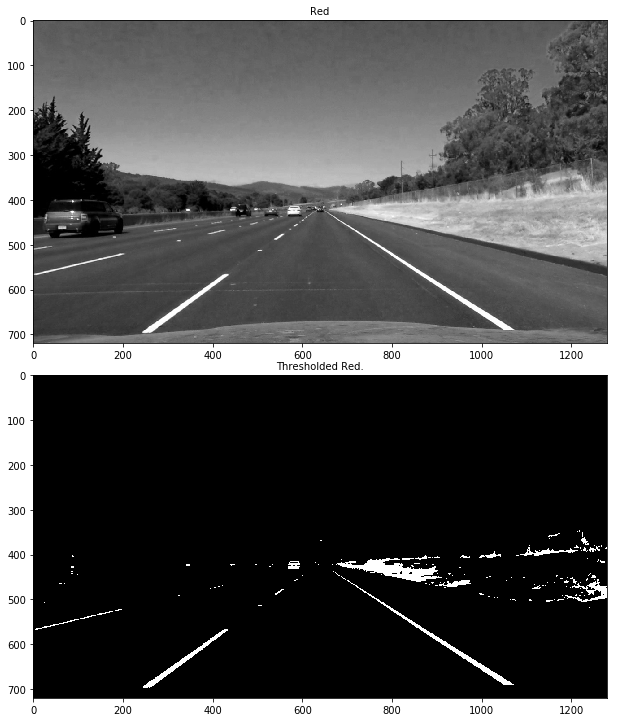

In [218]:
r_bin = color_thresh(r, thresh=(200, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
f.tight_layout()
ax1.imshow(r, cmap='gray')
ax1.set_title('Red', fontsize=10)
ax2.imshow(r_bin, cmap='gray')
ax2.set_title('Thresholded Red.', fontsize=10)

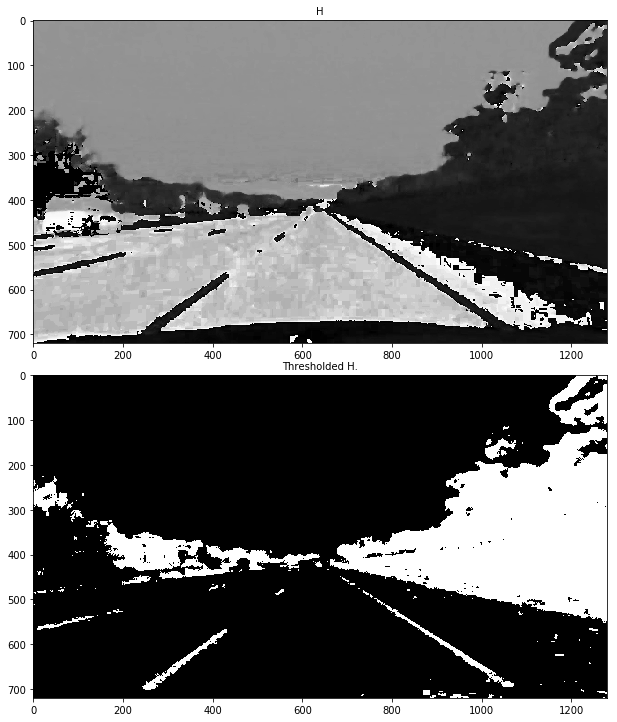

In [219]:
h_bin = color_thresh(h, thresh=(15, 35))

# Plot the result
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
f.tight_layout()
ax1.imshow(h, cmap='gray')
ax1.set_title('H', fontsize=10)
ax2.imshow(h_bin, cmap='gray')
ax2.set_title('Thresholded H.', fontsize=10)

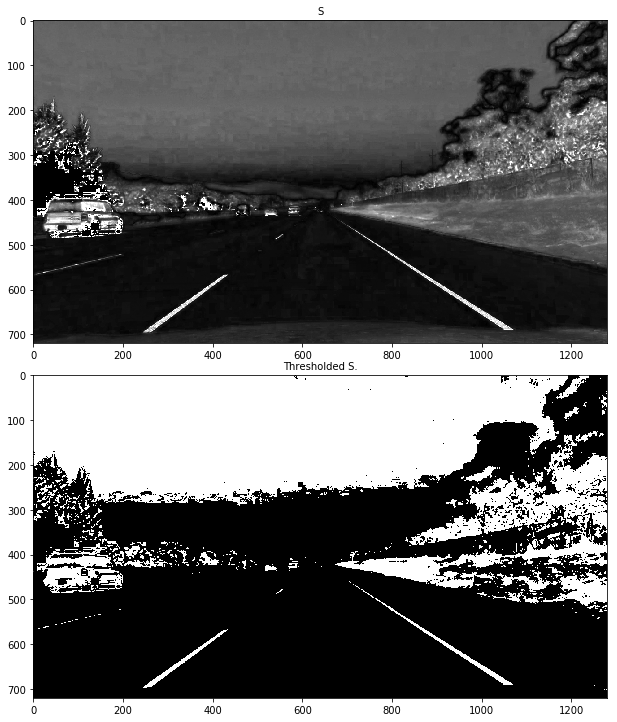

In [220]:
s_bin = color_thresh(s, thresh=(90, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
f.tight_layout()
ax1.imshow(s, cmap='gray')
ax1.set_title('S', fontsize=10)
ax2.imshow(s_bin, cmap='gray')
ax2.set_title('Thresholded S.', fontsize=10)

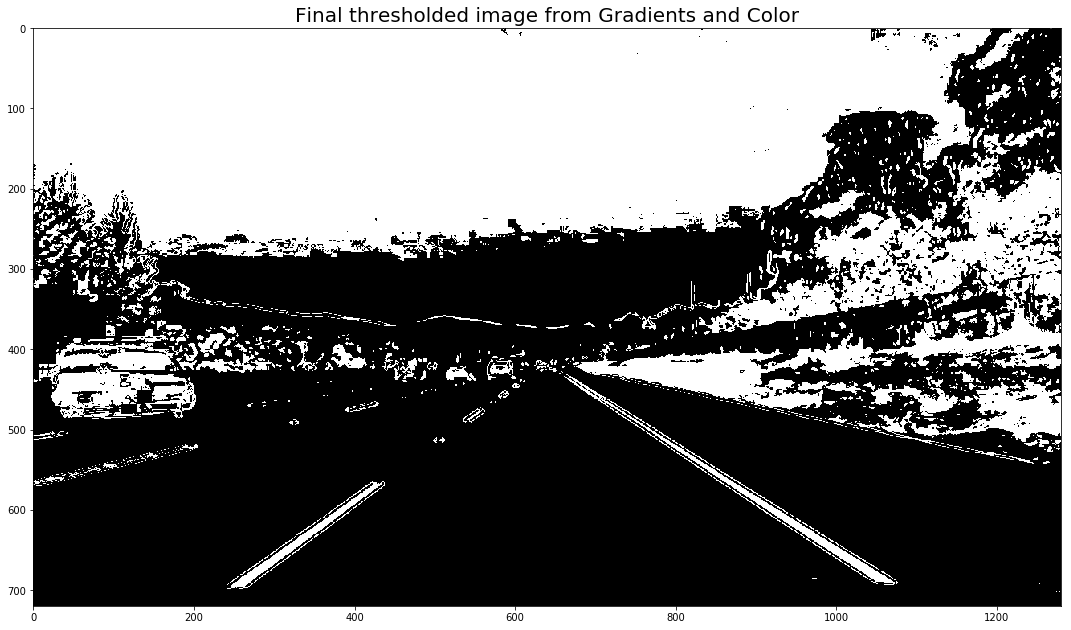

In [221]:
final_thres_bin_image = np.zeros_like(r)
final_thres_bin_image[(s_bin == 1)|(com_bin_threshold_image == 1)] = 1
# Plot the result
f, (ax1) = plt.subplots(1, 1, figsize=(15, 10))
f.tight_layout()
ax1.imshow(final_thres_bin_image, cmap='gray')
ax1.set_title('Final thresholded image from Gradients and Color', fontsize=20)

### Perspective Transformation

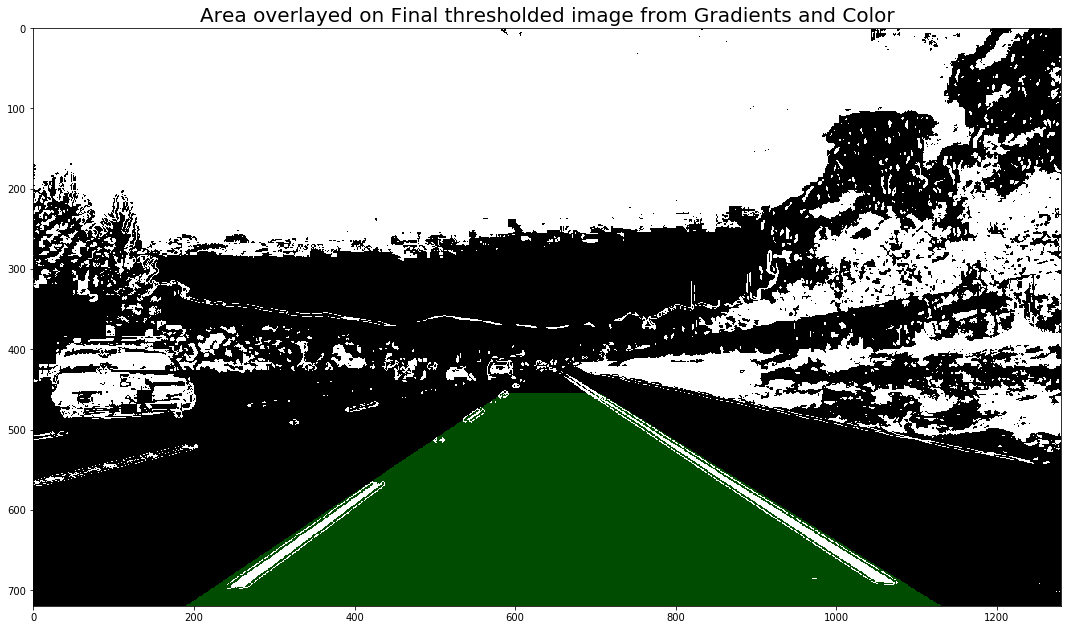

In [222]:
mapped_area = np.zeros_like(img).astype(np.uint8)
src_vertices = np.array([[[585,455],[705, 455], [1130,720], [190, 720]]], dtype=np.int32)
cv2.fillPoly(mapped_area, src_vertices, (0,255, 0))
out_img = np.dstack((final_thres_bin_image, final_thres_bin_image, final_thres_bin_image))*255

result = cv2.addWeighted(out_img, 1, mapped_area, 0.3, 0)
f, (ax1) = plt.subplots(1, 1, figsize=(15, 10))
f.tight_layout()
ax1.imshow(result)
ax1.set_title('Area overlayed on Final thresholded image from Gradients and Color', fontsize=20)

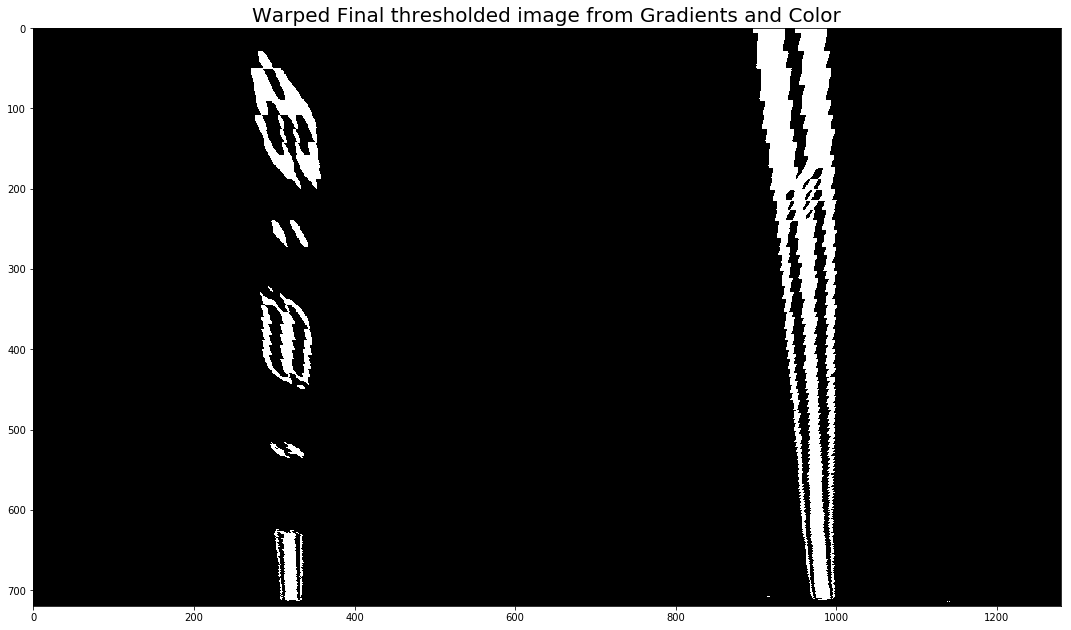

In [238]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(src_vertices[0])
    #print(src)
    dst = np.float32(
        [
            [300,  100],
            [1000, 100],
            [1000, 720],
            [300,  720]
        ])
    #print(dst)
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    return warped, M, Minv

warped_img, M, Minv = warp(final_thres_bin_image)
f, (ax1) = plt.subplots(1, 1, figsize=(15, 10))
f.tight_layout()
ax1.imshow(warped_img, cmap='gray')
ax1.set_title('Warped Final thresholded image from Gradients and Color', fontsize=20)

### Sliding Window scheme for finding lanes and curvature

(720, 1280)


C:\Users\vkrishnam\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


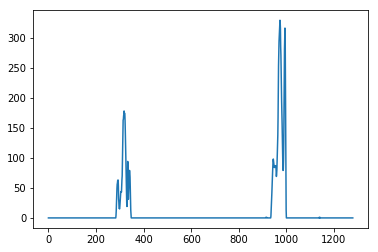

In [224]:
# Find the basePoints from Histogram
print(warped_img.shape)
histogram = np.sum(warped_img[warped_img.shape[0]/2:,:], axis=0)
plt.plot(histogram)

(720, 0)

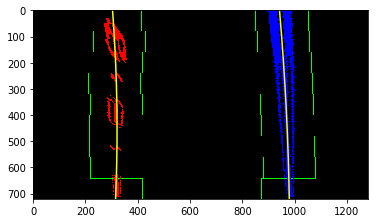

In [239]:
binary_warped = warped_img
out_img = np.dstack((warped_img, warped_img, warped_img))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint



# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []


# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Fidning lanes with the lanes fits

In [226]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

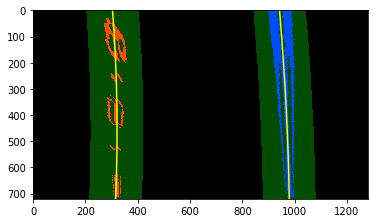

In [227]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Calculate the lane curvature and the vehicle offset from the road centre

In [230]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
print(y_eval)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

719.0
6093.37841425 10486.2851908


In [231]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

1995.9454129 m 3442.67334926 m


In [233]:
#Lane/Road center in pixels
left_fitx = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
right_fitx = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]

road_centre_in_pixels = (left_fitx+right_fitx)/2
image_centre_in_pixels = img.shape[1]/2

diff_in_pixels = (image_centre_in_pixels-road_centre_in_pixels)
diff_in_meters = diff_in_pixels*xm_per_pix

print('Car center is offset from road centre (in m)', diff_in_meters)

Car center is offset from road centre (in m) -0.0397155718536


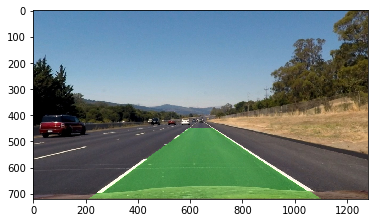

In [240]:
warped = binary_warped

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
plt.imshow(result)